In [1]:
import torch
from utils.mnist_reader import load_mnist
from Dataset import Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.nn.functional import fold, unfold
from torch.nn import Parameter

In [2]:
print(torch.__version__)
print(torch.backends.cudnn.enabled)
print(torch.cuda.is_available())
print(torch.version.cuda)

1.4.0
True
True
10.1


### Data preprocessing

In [3]:
data = load_mnist("data/fashion/")
x = data[0]/255.0
y = data[1]

In [4]:
data[0].shape

(60000, 784)

In [5]:
#Getting one (first) representative from each class
classes, index_sample = np.unique(y,return_index=True)
class_sample = x[index_sample]

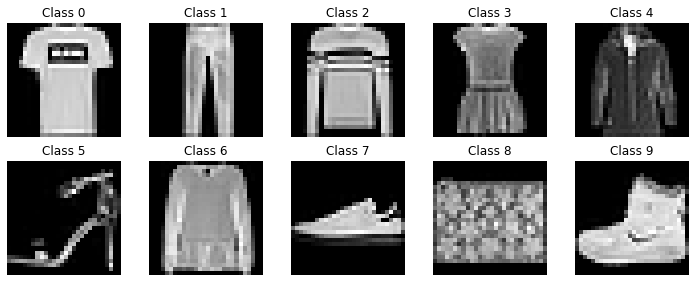

In [6]:
#Displaying the class representatives
NROWS = 2
NCOLS = 5
reshaped = class_sample.reshape(-1,28,28)

plt.figure(figsize=(10,4))
for i in range(NROWS * NCOLS):
    plt.subplot(NROWS, NCOLS, i+1)
    plt.imshow(reshaped[i],cmap='gray')
    plt.title(f"Class {classes[i]}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [7]:
#Shaping the data to the 1 channel, 2d greyscale image
x_train, x_val, y_train, y_val = train_test_split(
    x.reshape(-1,1,28,28), y, test_size=0.2
)
#One-hot encoding
encd = OneHotEncoder(sparse=False)
y_train = encd.fit_transform(y_train.reshape(-1,1))
y_val = encd.transform(y_val.reshape(-1,1))
#PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [8]:
#Use dataset (from Dataset.py file) to create two datasets
BSIZE = 16
TRAIN = Dataset(x_train,y_train, batch_size=BSIZE)
VALID = Dataset(x_val,y_val, batch_size=BSIZE)

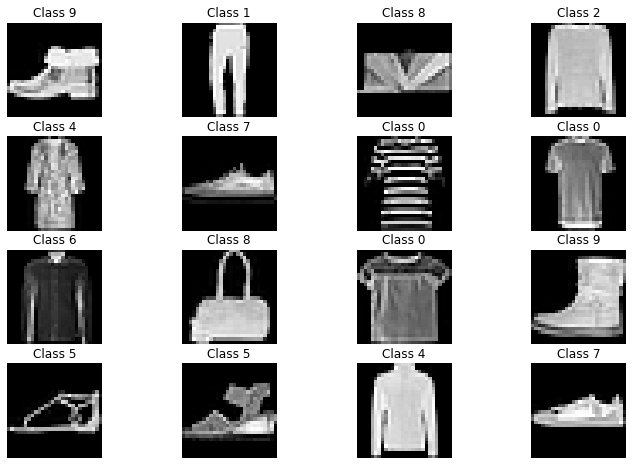

In [12]:
#Yet another visualisation
plt.figure(figsize=(12, 8))

# Choose one random batch
inputs, labels = TRAIN.__getitem__(112)

# Decode one-hot encoded labels
decoded_labels = np.argmax(labels, axis=1)

# Iterate over individual samples in the batch
for i in range(BSIZE):
    plt.subplot(4, 4, i + 1)
    plt.imshow(inputs[i, 0], cmap='gray')
    plt.title(f"Class {decoded_labels[i]}")
    plt.axis('off')

plt.show()

### Implementation of ReLU, Maxpool 2D, and 2D Convolution

In [13]:
class ReLU(torch.nn.Module) :
    def __init__(self):
        super( ).__init__( )
    
    def forward(self, x):
        return torch.where(x < 0, torch.tensor(0.0), x)

In [14]:
class Conv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.kernel_size = (kernel_size, kernel_size) if not isinstance(kernel_size, tuple) else kernel_size
        self.stride = (stride, stride) if not isinstance(stride, tuple) else stride
        self.weight = Parameter(torch.randn(out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]))
        self.bias = Parameter(torch.randn(out_channels))
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, x):
        # Extract patches from the input
        unfolded_x = unfold(x, self.kernel_size, stride=self.stride)
        
        # Dimensional magic
        unfolded_x = unfolded_x.transpose(1, 2)
        
        # More dimensional magic
        weight_matrix = self.weight.view(self.weight.size(0), -1).t()
        
        # Perform matrix multiplication
        out_unf = unfolded_x.matmul(weight_matrix).transpose(1, 2)
                
        # Calculate the output shape based on the input and convolutional kernel
        out_shape = (
            x.size(0),
            self.weight.size(0),
            (x.size(2) - self.kernel_size[0])//self.stride[0] + 1,
            (x.size(3) - self.kernel_size[1])//self.stride[1] + 1
        )
            
        # Fold back
        out = fold(out_unf, out_shape[-2:], (1,1))
        out = out + self.bias.view(1, -1, 1, 1)
        
        return out

In [15]:
class MaxPool2d(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = (kernel_size, kernel_size) if not isinstance(kernel_size, tuple) else kernel_size
        self.stride = (stride, stride) if not isinstance(stride, tuple) else stride
        
    def forward(self,x):
        # Extract patches from the input
        unfolded_x = unfold(x, self.kernel_size, stride=self.stride)
        
        # Dimensional magic
        unfolded_x = unfolded_x.view(unfolded_x.size(0), x.size(1), -1, unfolded_x.size(-1))

        
        #Find max in dimension 2
        out_unf,_ = unfolded_x.max(dim=2)
        
        # Calculate the output shape based on the input and pooling kernel
        out_shape = (
            x.size(0),
            x.size(1),
            (x.size(2) - self.kernel_size[0])//self.stride[0] + 1,
            (x.size(3) - self.kernel_size[1])//self.stride[1] + 1
        )
        
        out = fold(out_unf, out_shape[-2:], (1, 1))
        
        return out

In [16]:
dx,dy = TRAIN[355]

In [17]:
dx.shape

torch.Size([16, 1, 28, 28])

#### Check ReLU

In [18]:
#Compare results (tests)
f_relu = ReLU()
g_relu = torch.nn.ReLU()
g_conv2d = torch.nn.Conv2d(5,4,4)
random_tensors = [torch.randn(4, 5, 5, 10) for _ in range(100)]
RELU_RESULTS = [torch.equal(f_relu(tensor), g_relu(tensor)) for tensor in random_tensors]
CONV2D_RESULTS = [g_conv2d(tensor) for tensor in random_tensors]
print(f"All ReLU cheks OK: {all(RELU_RESULTS)}")

All ReLU cheks OK: True


#### Check Conv2D

In [19]:
# Create an instance of the custom Conv2d layer
custom_conv2d = Conv2d(in_channels=1, out_channels=4, kernel_size=(3,3), stride=1)
pytorch_conv2d = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3,3), stride=1)

In [20]:
pytorch_conv2d.weight = custom_conv2d.weight
pytorch_conv2d.bias = custom_conv2d.bias

In [21]:
# Check if both output same results with same weights and bias
custom_output = custom_conv2d(dx)
pytorch_output = pytorch_conv2d(dx)

In [22]:
torch.allclose(custom_output, pytorch_output, atol=1e-5)

True

#### Check MaxPool

In [23]:
custom_maxpool = MaxPool2d(kernel_size=(3,3),stride=2)
pytorch_maxpool = torch.nn.MaxPool2d(kernel_size=(3,3),stride=2)

In [24]:
# Check if both output same results
custom_output = custom_maxpool(dx)
pytorch_output = pytorch_maxpool(dx)

In [25]:
torch.allclose(custom_output, pytorch_output, atol=1e-5)

True

### Effects of operation order

In [26]:
random_tensor = torch.rand(1, 1, 100, 100)
random_tensor = 2 * random_tensor - 1

In [27]:
torch.min(random_tensor), torch.max(random_tensor)

(tensor(-0.9995), tensor(0.9997))

In [28]:
mx2b = MaxPool2d(kernel_size=(3,3),stride=2)
reLU = ReLU()

#### MaxPool2D, then ReLU

In [29]:
random_tensor.shape

torch.Size([1, 1, 100, 100])

In [30]:
maxfirst = reLU(mx2b(random_tensor))
print(maxfirst)

tensor([[[[0.9650, 0.8441, 0.9920,  ..., 0.9436, 0.9436, 0.8710],
          [0.7900, 0.4161, 0.9920,  ..., 0.9436, 0.9436, 0.4758],
          [0.7900, 0.4447, 0.4447,  ..., 0.7216, 0.2474, 0.7883],
          ...,
          [0.8108, 0.8108, 0.6613,  ..., 0.9937, 0.8598, 0.8444],
          [0.9523, 0.8108, 0.6613,  ..., 0.6365, 0.8598, 0.6096],
          [0.8745, 0.8745, 0.9992,  ..., 0.6365, 0.6161, 0.8937]]]])


#### ReLU, then MaxPool2D

In [31]:
relfirst = mx2b(reLU(random_tensor))
print(relfirst)

tensor([[[[0.9650, 0.8441, 0.9920,  ..., 0.9436, 0.9436, 0.8710],
          [0.7900, 0.4161, 0.9920,  ..., 0.9436, 0.9436, 0.4758],
          [0.7900, 0.4447, 0.4447,  ..., 0.7216, 0.2474, 0.7883],
          ...,
          [0.8108, 0.8108, 0.6613,  ..., 0.9937, 0.8598, 0.8444],
          [0.9523, 0.8108, 0.6613,  ..., 0.6365, 0.8598, 0.6096],
          [0.8745, 0.8745, 0.9992,  ..., 0.6365, 0.6161, 0.8937]]]])


In [32]:
torch.equal(relfirst,maxfirst)

True

It does not matter which one is applied first. Moreover, it should be the same for any input. However, Conv2d is a linear operation, so it has to come before the activation. 

### Construction of neural network

In [33]:
from torch.nn import Sequential, Flatten

In [34]:
#Use dataset (from Dataset.py file) to create two datasets
BSIZE = 32
TRAIN = Dataset(x_train,y_train, batch_size=BSIZE)
VALID = Dataset(x_val,y_val, batch_size=BSIZE)

In [35]:
x,y = TRAIN[123]

In [36]:
x.shape

torch.Size([32, 1, 28, 28])

In [66]:
#Layers
c2d_bb1 = Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),stride=1)
PY_c2d_bb1 = torch.nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),stride=1)
PY_c2d_bb1.weight = c2d_bb1.weight
PY_c2d_bb1.bias = c2d_bb1.bias
mp_bb1 = MaxPool2d(kernel_size=(3,3),stride=2)
relu = ReLU()
c2d_bb2 = Conv2d(in_channels=10,out_channels=64,kernel_size=(3,3),stride=1)
PY_c2d_bb2 = torch.nn.Conv2d(in_channels=10,out_channels=64,kernel_size=(3,3),stride=1)
PY_c2d_bb2.weight = c2d_bb2.weight
PY_c2d_bb2.bias = c2d_bb2.bias
mp_bb2 = MaxPool2d(kernel_size=(3,3),stride=2)
c2d_out = Conv2d(in_channels=64,out_channels=10,kernel_size=(4,4),stride=1)
PY_c2d_out = torch.nn.Conv2d(in_channels=64,out_channels=10,kernel_size=(4,4),stride=1)
PY_c2d_out.weight = c2d_out.weight
PY_c2d_out.bias = c2d_out.bias
flat = Flatten()

In [67]:
pytorch_model = Sequential(
    PY_c2d_bb1,
    torch.nn.MaxPool2d(kernel_size=(3,3),stride=2),
    torch.nn.ReLU(),
    PY_c2d_bb2,
    torch.nn.MaxPool2d(kernel_size=(3,3),stride=2),
    torch.nn.ReLU(),
    PY_c2d_out,
    flat
)
custom_model = Sequential(
    c2d_bb1,
    mp_bb1,
    relu,
    c2d_bb2,
    mp_bb2,
    relu,
    c2d_out,
    flat
)

In [68]:
torch.allclose(pytorch_model(x),custom_model(x),atol=10e-5)

True

### Fitting the models

In [69]:
from torch.utils.data import DataLoader

In [70]:
#Use dataset (from Dataset.py file) to create two datasets
BSIZE = 128
TRAIN = Dataset(x_train,y_train, batch_size=BSIZE)
VALID = Dataset(x_val,y_val, batch_size=BSIZE)

In [71]:
def fit(model, train, validation, epochs=10, batch_size=BSIZE):
    #Loss function
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    
    best_model = None
    best_valid_loss = float('inf')
    training_losses = []
    validation_losses = []
    
    for epoch in range(epochs):
        #Train
        model.train()
        train_loss = 0.0
        
        idx = torch.randint(0, len(train), (1,))
        inputs, labels = train[idx]
        
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        training_losses.append(train_loss/BSIZE)
        
        #Validation
        model.eval()
        valid_loss = 0.0
        
        idx = torch.randint(0, len(validation), (1,))
        inputs, labels = validation[idx]
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        
        valid_loss += loss.item()
        validation_losses.append(valid_loss/BSIZE)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model.state_dict()
    
    model.load_state_dict(best_model)
    return model, training_losses, validation_losses

In [72]:
final_model, training_loss, validation_loss = fit(custom_model,TRAIN,VALID,epochs=10)

In [73]:
print(training_loss)
print(validation_loss)

[11.12713623046875, 178.15994262695312, 1.4433375597000122, 0.3361666202545166, 0.15528053045272827, 0.11098884791135788, 0.08829808980226517, 0.05336947366595268, 0.036334410309791565, 0.03202288597822189]
[127.15933227539062, 1.356086254119873, 0.3974074721336365, 0.14049743115901947, 0.12283878028392792, 0.08155589550733566, 0.061035823076963425, 0.042152728885412216, 0.036893393844366074, 0.027849247679114342]


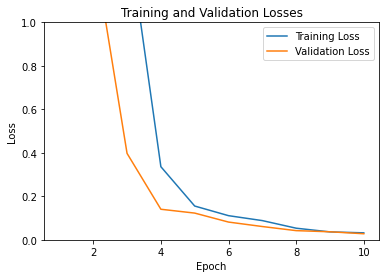

In [74]:
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [75]:
pytorch_final_model, PY_training_loss, PY_validation_loss = fit(pytorch_model,TRAIN,VALID,epochs=10)

In [76]:
print(PY_training_loss)
print(PY_validation_loss)

[0.029687048867344856, 0.02690223418176174, 0.02325873076915741, 0.024082258343696594, 0.02978292480111122, 0.058113545179367065, 0.02932371199131012, 0.02484031766653061, 0.0216904878616333, 0.019323652610182762]
[0.02754056826233864, 0.0254333708435297, 0.023978382349014282, 0.029086869210004807, 0.06188318878412247, 0.03270839899778366, 0.021026231348514557, 0.021733717992901802, 0.020395930856466293, 0.0199215617030859]


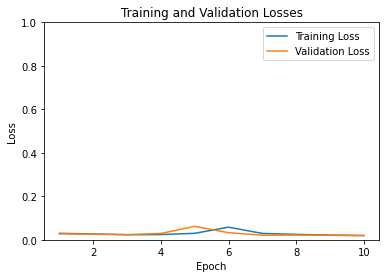

In [77]:
epochs = range(1, len(PY_training_loss) + 1)

plt.plot(epochs, PY_training_loss, label='Training Loss')
plt.plot(epochs, PY_validation_loss, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

There is a difference. Our model starts with a very large loss - and barely manages to reach the default model performance. Potential sources of difference include, but are not limited to:
- Our convolution and maxpool functions are implemented naively
- Potential mistakes in the implementation

### Bonus

In [78]:
#Use dataset (from Dataset.py file) to create two datasets
BSIZE = 128
TRAIN = Dataset(x_train,y_train, batch_size=BSIZE)
VALID = Dataset(x_val,y_val, batch_size=BSIZE)
#x, y = TRAIN[113]

In [79]:
from performance import plot_stats

In [80]:
some_other_model = Sequential(
    torch.nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),stride=1),
    torch.nn.MaxPool2d(kernel_size=(3,3),stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=10,out_channels=64,kernel_size=(3,3),stride=1),
    torch.nn.MaxPool2d(kernel_size=(3,3),stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=64,out_channels=10,kernel_size=(4,4),stride=1),
    torch.nn.Flatten(),
    #torch.nn.Linear(10, 256),
    #torch.nn.ReLU(),
    #torch.nn.Linear(256, 10),
    #torch.nn.Softmax(dim=1)
)

In [86]:
the_model, the_training_loss, the_validation_loss = fit(some_other_model,TRAIN,VALID,epochs=30)

In [87]:
the_model.eval()

Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(64, 10, kernel_size=(4, 4), stride=(1, 1))
  (7): Flatten()
)

In [88]:
predictions = the_model(VALID.x)

gt = VALID.y

In [89]:
print(predictions.shape)
print(gt.shape)

torch.Size([12000, 10])
torch.Size([12000, 10])


TypeError: got an unexpected keyword argument 'labels'

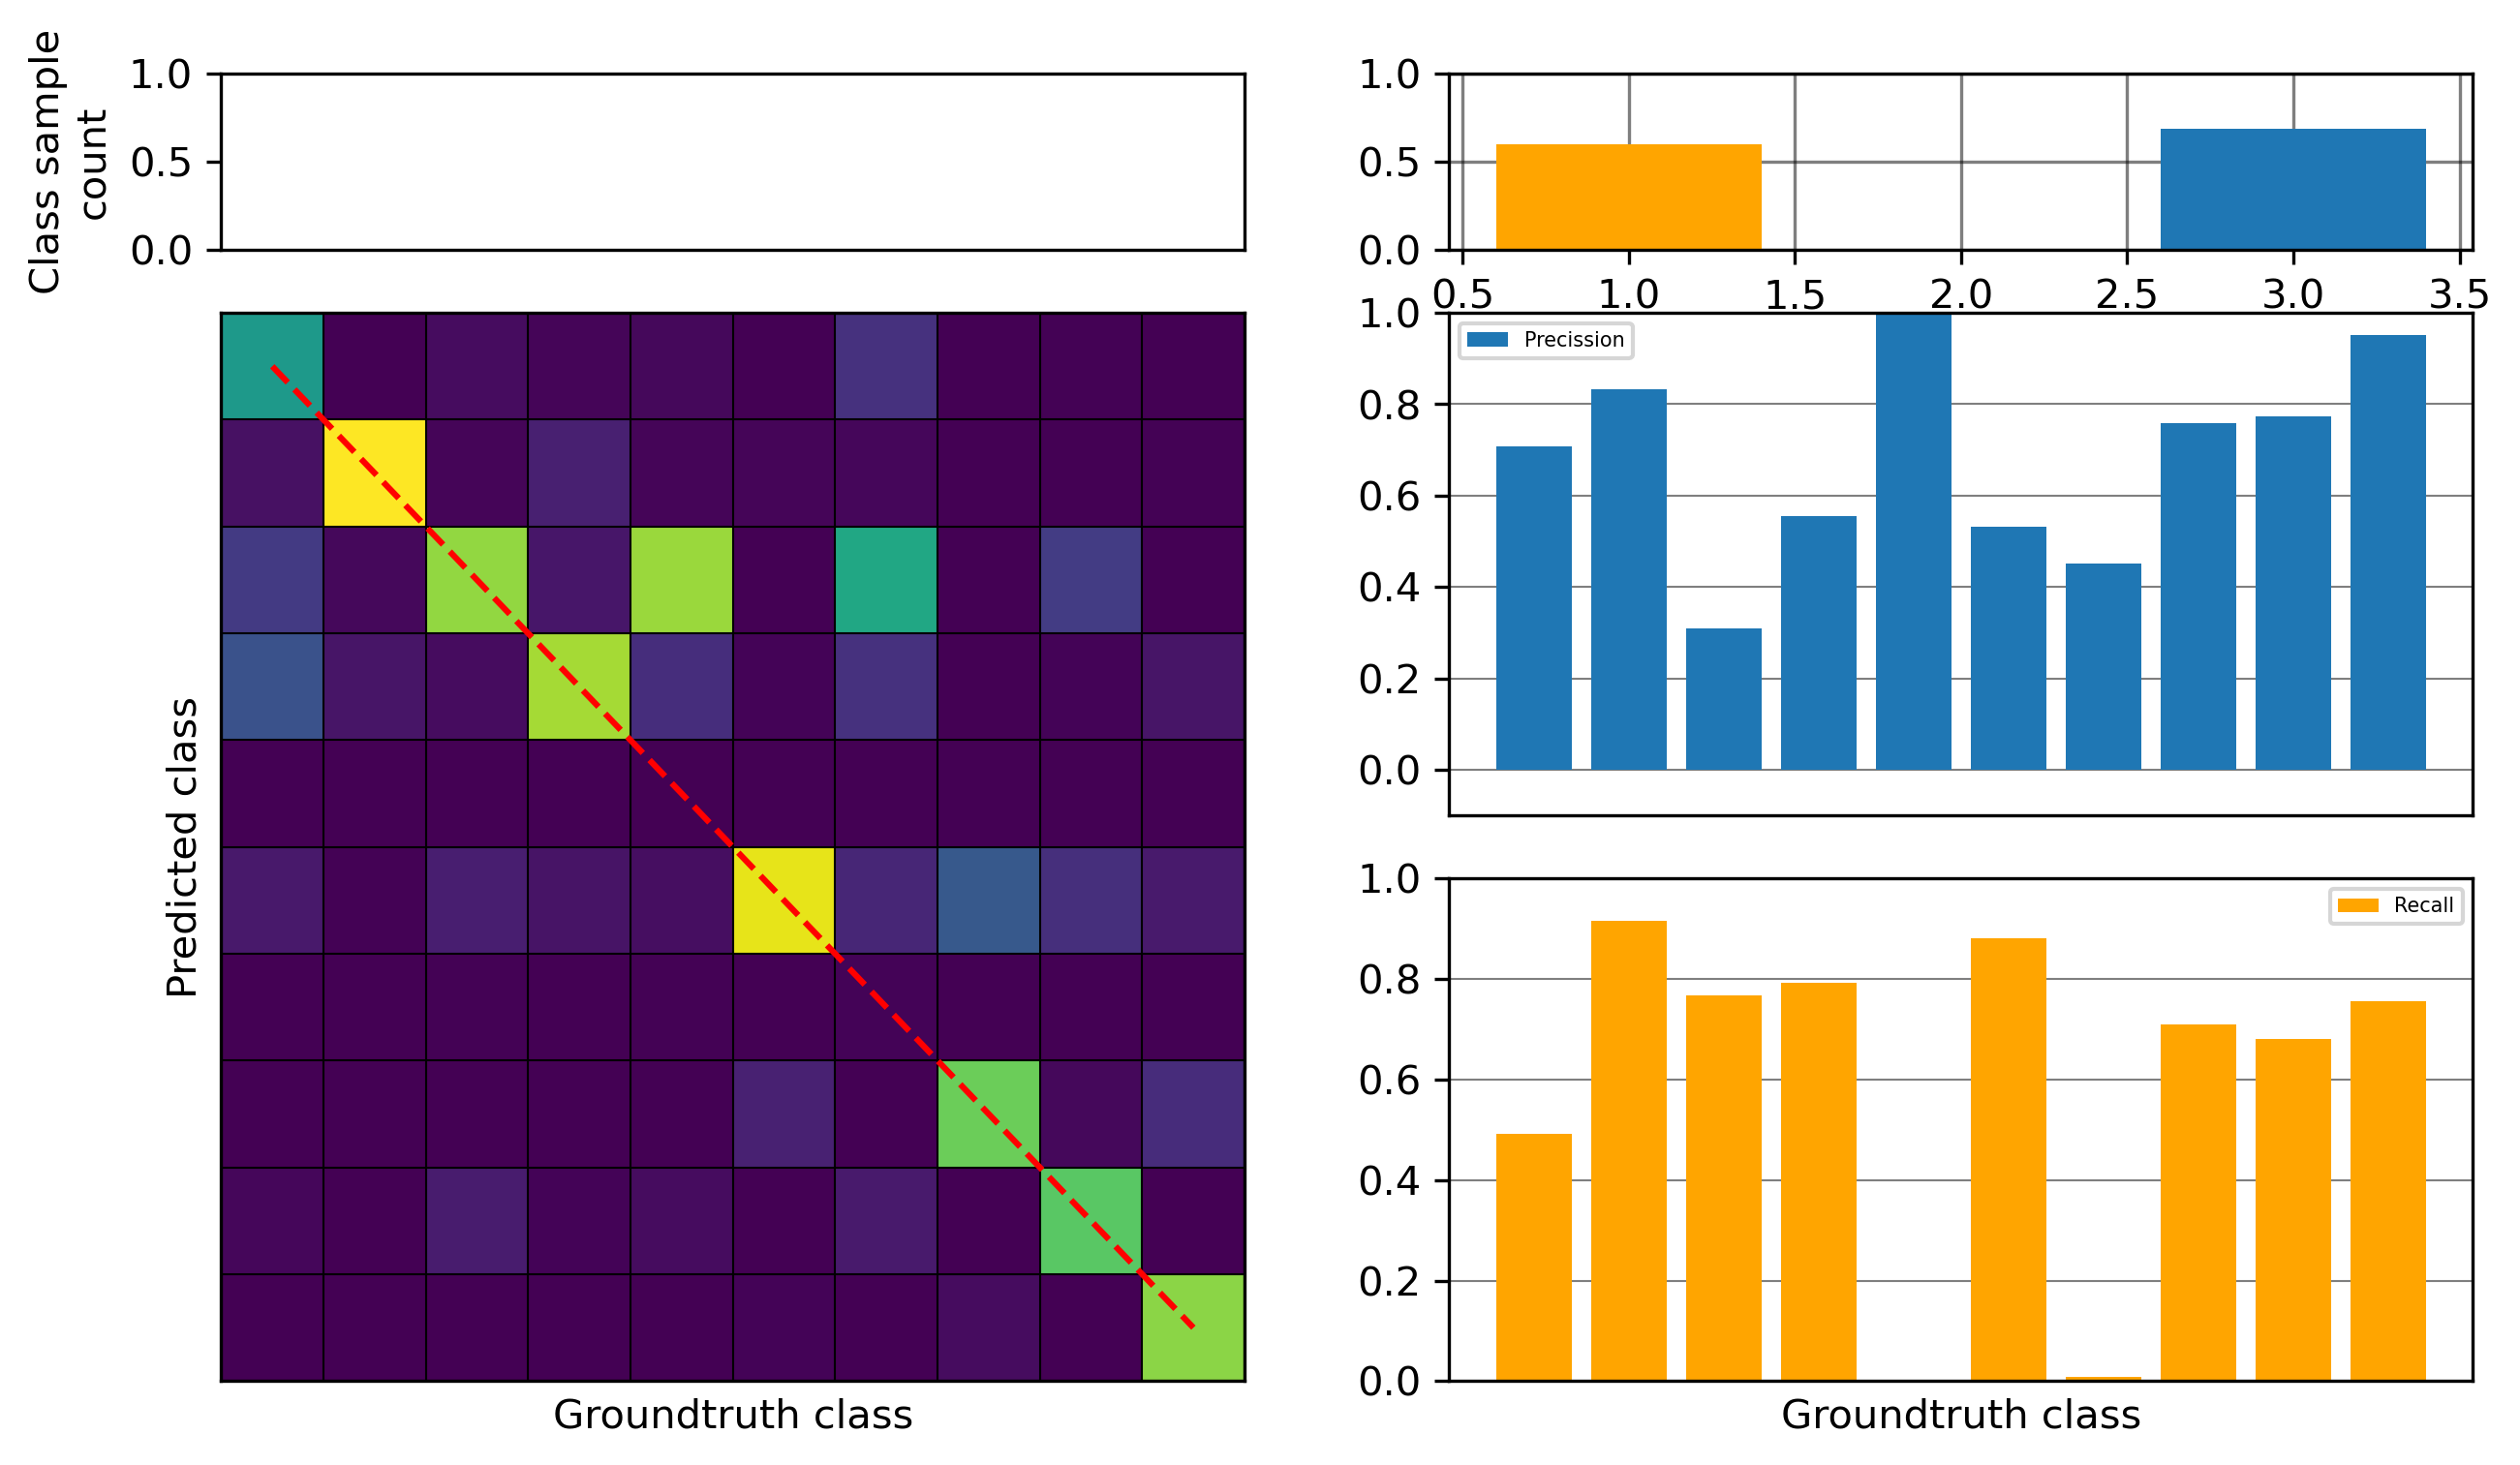

In [90]:
plot_stats(predictions.detach().numpy(),gt.numpy())